In [1]:
import sys
import os
from dotenv import load_dotenv

sys.path.append(os.path.abspath('src'))

In [2]:
import SoccerNet
from SoccerNet.Downloader import SoccerNetDownloader

mySoccerNetDownloader=SoccerNetDownloader(LocalDirectory="SoccerNet")
load_dotenv()
mySoccerNetDownloader.password = os.getenv("SOCCERNET_KEY")

# # Downloading the annotations of the 500 games
# mySoccerNetDownloader.downloadGames(files=["Labels-v2.json"], split=["train","valid","test"])

# mySoccerNetDownloader.downloadGames(files=["1_ResNET_TF2_PCA512.npy", "2_ResNET_TF2_PCA512.npy"], split=["train","valid","test","challenge"])

In [3]:
from utils import Utilities
utilities = Utilities("SoccerNet")

# utilities.save_labels_in_csv()

Training data distribution:


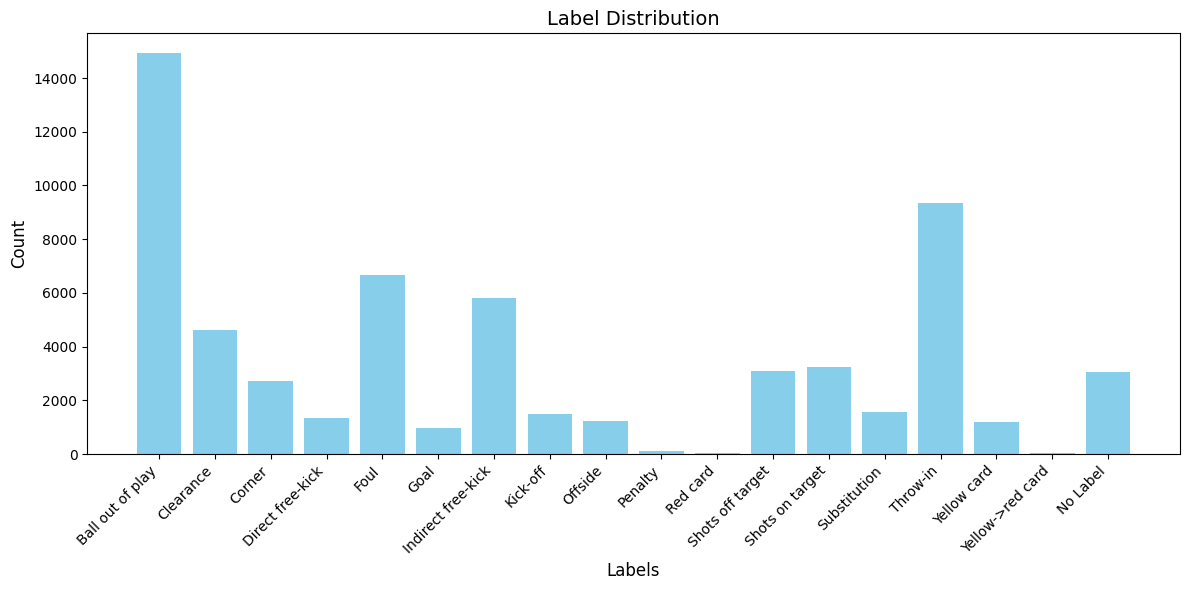

Validation data distribution:


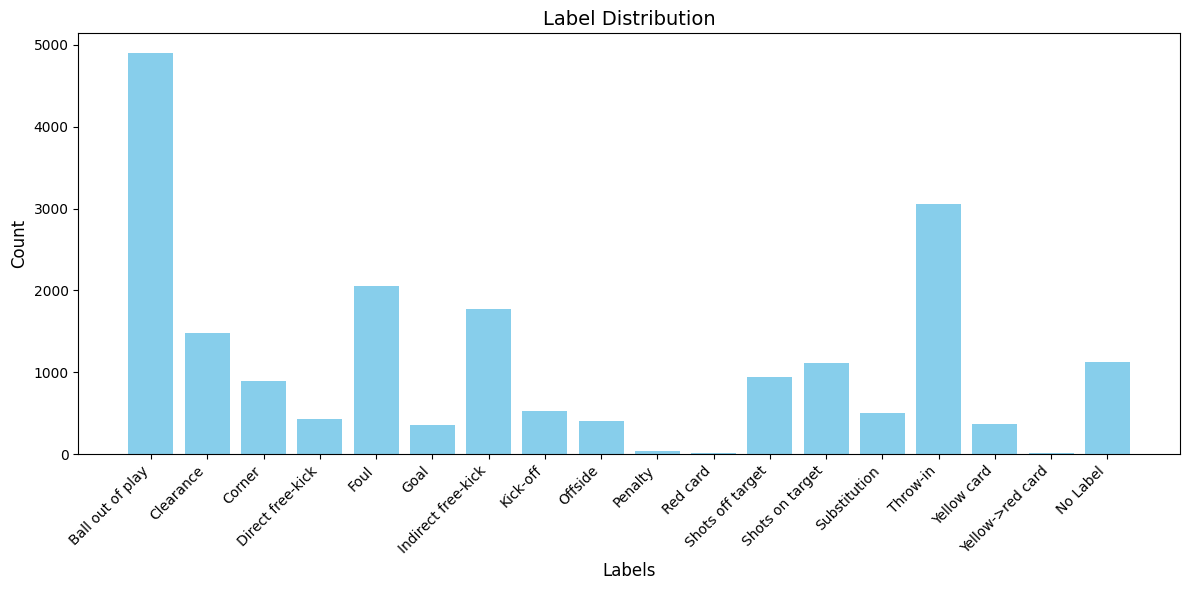

Test data distribution:


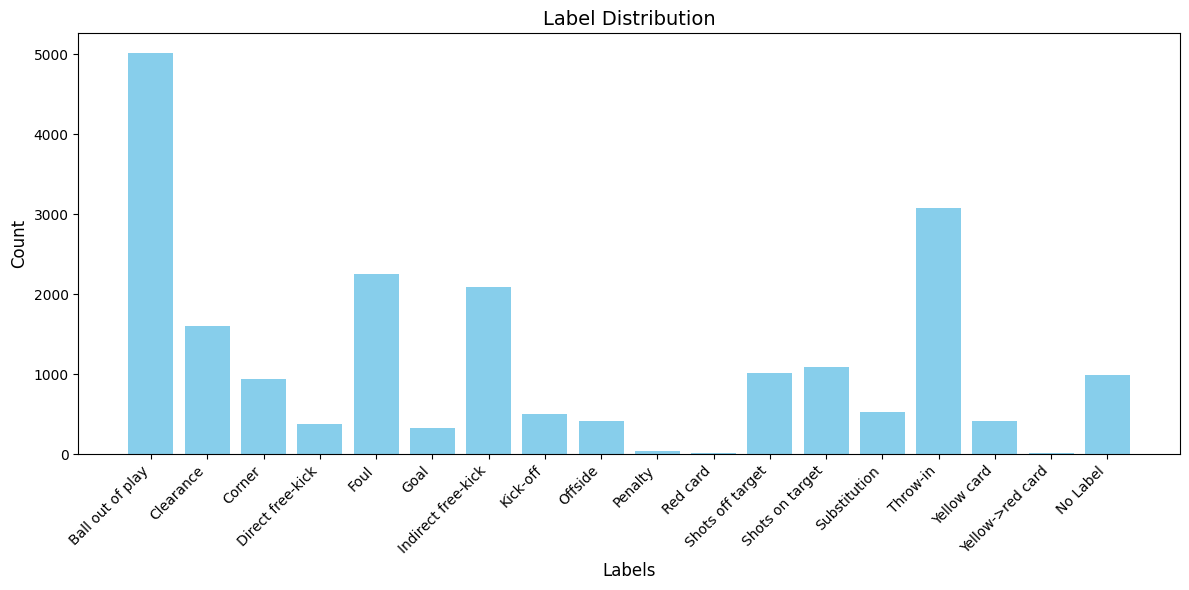

In [4]:
from data_loading import DataLoading

batch_size = 32
fps = 2
chunk_length = 60

train_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="train")
val_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="valid")
test_dataloading = DataLoading("SoccerNet", fps, chunk_length, batch_size, split_type="test")

train_loader = train_dataloading.get_dataloader()
val_loader = val_dataloading.get_dataloader()
test_loader = test_dataloading.get_dataloader()

print("Training data distribution:")
train_dataloading.show_label_distribution()
print("Validation data distribution:")
val_dataloading.show_label_distribution()
print("Test data distribution:")
test_dataloading.show_label_distribution()


In [5]:
import torch
from torch.utils.data import DataLoader
import model
import numpy as np

from training import Trainer

model = model.Model(input_dim=512, num_classes=17)


Epoch 1/50: Loss = 0.3231, training mAP = 0.3657, validation mAP = 0.3395
Epoch 2/50: Loss = 0.2523, training mAP = 0.4303, validation mAP = 0.3766
Epoch 3/50: Loss = 0.2441, training mAP = 0.4569, validation mAP = 0.3927
Epoch 4/50: Loss = 0.2386, training mAP = 0.4828, validation mAP = 0.4005
Epoch 5/50: Loss = 0.2342, training mAP = 0.5066, validation mAP = 0.4162
Epoch 6/50: Loss = 0.2307, training mAP = 0.5252, validation mAP = 0.4167
Epoch 7/50: Loss = 0.2275, training mAP = 0.5430, validation mAP = 0.4296
Epoch 8/50: Loss = 0.2243, training mAP = 0.5620, validation mAP = 0.4215
Epoch 9/50: Loss = 0.2218, training mAP = 0.5752, validation mAP = 0.4267
Epoch 10/50: Loss = 0.2182, training mAP = 0.5919, validation mAP = 0.4275
Epoch 11/50: Loss = 0.2161, training mAP = 0.6082, validation mAP = 0.4281
Epoch 12/50: Loss = 0.2131, training mAP = 0.6162, validation mAP = 0.4255
Epoch 13/50: Loss = 0.2103, training mAP = 0.6339, validation mAP = 0.4378
Epoch 14/50: Loss = 0.2076, traini

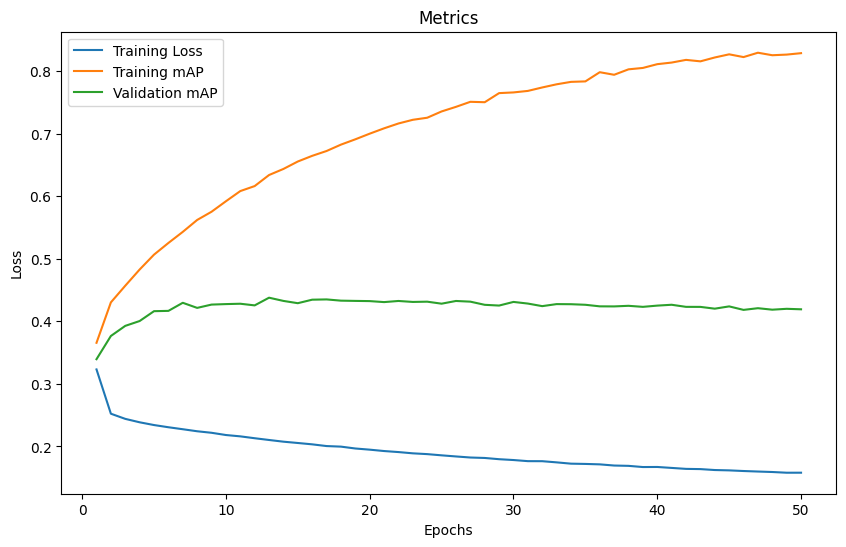

In [6]:
trainer = Trainer(model, train_loader, val_loader, epochs=100, batch_size=batch_size, prediction_threshold=0.5)
trainer.train()

In [7]:
trainer.save_checkpoint("weights/model_0_1.pth")

AttributeError: 'Model' object has no attribute 'model_architecture'

In [ ]:
# Downloading the videos of the 500 games
mySoccerNetDownloader.downloadGames(files=["1_224p.mkv", "2_224p.mkv"], split=["train","valid","test","challenge"])

In [ ]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 20)
pd.set_option('display.colheader_justify', 'center')

annotations_df = utilities.parse_labels_json()
annotations_engineered_df = utilities.parse_labels_json_with_feature_engineering()

display(annotations_df.head())
annotations_df.to_csv("annotations.csv", index=False)

display(annotations_engineered_df.head(100))
annotations_engineered_df.to_csv("annotations_engineered.csv", index=False)

In [ ]:
print("Number of rows:", annotations_engineered_df.shape[0])
print("Number of columns:", annotations_engineered_df.shape[1])

In [ ]:
print("DataFrame Info:")
print(annotations_engineered_df.info())

In [ ]:
print("Missing Values per Column:")
print(annotations_engineered_df.isnull().sum())


In [ ]:
print("Descriptive Statistics (Including Non-Numerical):")
display(annotations_engineered_df.describe(include='all'))

In [ ]:
# Number of unique labels (excluding game-related columns)
label_columns = [col for col in annotations_engineered_df.columns if col.startswith('label_')]
unique_labels = len(label_columns)
print("Number of unique labels:", unique_labels)

# List of unique labels (based on the column names)
print("Unique labels:", label_columns)


In [ ]:
utilities.print_labels_distribution(annotations_engineered_df)

In [ ]:
utilities.print_labels_frequency(annotations_engineered_df)

In [ ]:
utilities.print_labels_frequency_per_league(annotations_engineered_df)

In [ ]:
utilities.print_labels_distribution_over_game_intervals(annotations_engineered_df)